In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
import matplotlib as mpl
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.modeling.models import BlackBody
from scipy import stats
import astrotools.orbitparams as orb
import astrotools.generateExoplanetTable as genTable
import pickle
import json
import starry as st
import copy
import os
st.config.lazy = False
from jwst_backgrounds import jbt
import pandeia.engine
from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.instrument_factory import InstrumentFactory
from pandeia.engine.perform_calculation import perform_calculation

pandeia.engine.pandeia_version()

Pandeia Engine version:  2.0
Pandeia RefData version:  2.0
Synphot Data:  /home/hannah/programs/grp-2.0/redcat/trds


## Provide stellar parameters
Ideally these will be read from a database; implemente later

In [39]:
# grab a table of transiting terrestrial exoplanets from NASA Exoplante Archive
try: smallPlanetSystems = ascii.read('./NASAExoArchive_TransitingExoplanetTable.dat')
except:
    thiswd = os.getcwd()
    smallPlanetSystems = genTable.generateTransitingExoTable(outputpath=thiswd, 
                                                             sy_dist_upper=25, 
                                                             st_rad_upper=0.35, 
                                                             pl_rade_upper=1.85, 
                                                             pl_per_upper=30)

In [73]:
smallPlanetSystems.pprint(max_lines=40, show_unit=True)

 hostname    pl_name     sy_dist      rastr     ... pl_orbincl tran_flag rv_flag
                                                ...                             
---------- ------------ ---------- ------------ ... ---------- --------- -------
   GJ 1132    GJ 1132 b     12.613 10h14m50.18s ...      86.58         1       1
    GJ 357     GJ 357 b    9.44181 09h36m01.79s ...      89.12         1       1
   GJ 3929    GJ 3929 b    15.8095 15h58m18.62s ...     88.442         1       1
    GJ 486     GJ 486 b    8.07426 12h47m55.57s ...       88.4         1       1
   L 98-59    L 98-59 c    10.6194 08h18m07.89s ...      88.11         1       1
   L 98-59    L 98-59 d    10.6194 08h18m07.89s ...     88.449         1       1
   L 98-59    L 98-59 b    10.6194 08h18m07.89s ...      87.71         1       1
  LHS 1140   LHS 1140 c    14.9861 00h44m59.67s ...     89.913         1       1
  LHS 1140   LHS 1140 b    14.9861 00h44m59.67s ...     89.877         1       1
  LHS 1478   LHS 1478 b    1

In [74]:
smallPlanetSystems

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_teff,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbsmax,pl_orbincl,tran_flag,rv_flag
str10,str12,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
GJ 1132,GJ 1132 b,12.613,10h14m50.18s,-47d09m17.77s,8.322,0.18,0.21,3270.0,0.5,0.056,-0.056,1.66,0.23,-0.23,1.628931,0.0153,86.58,1,1
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,0.34,0.34,3505.0,1.217,0.084,-0.083,1.84,0.31,-0.31,3.93072,0.035,89.12,1,1
GJ 3929,GJ 3929 b,15.8095,15h58m18.62s,+35d24m29.21s,7.869,0.31,0.32,3384.0,1.09,0.04,-0.04,1.75,0.44,-0.45,2.616235,0.0252,88.442,1,1
GJ 486,GJ 486 b,8.07426,12h47m55.57s,+09d44m57.91s,6.362,0.32,0.33,3340.0,1.305,0.063,-0.067,2.82,0.11,-0.12,1.467119,0.01734,88.4,1,1
L 98-59,L 98-59 c,10.6194,08h18m07.89s,-68d18m52.08s,7.101,0.27,0.3,3415.0,1.385,0.095,-0.075,2.22,0.26,-0.25,3.6906777,0.0304,88.11,1,1
L 98-59,L 98-59 d,10.6194,08h18m07.89s,-68d18m52.08s,7.101,0.27,0.3,3415.0,1.521,0.119,-0.098,1.94,0.28,-0.28,7.4507245,0.0486,88.449,1,1
L 98-59,L 98-59 b,10.6194,08h18m07.89s,-68d18m52.08s,7.101,0.27,0.3,3415.0,0.85,0.061,-0.047,0.4,0.16,-0.15,2.2531136,0.02191,87.71,1,1
LHS 1140,LHS 1140 c,14.9861,00h44m59.67s,-15d16m26.79s,8.821,0.19,0.21,2988.0,1.169,0.037,-0.038,1.76,0.17,-0.16,3.77792,0.02734,89.913,1,1
LHS 1140,LHS 1140 b,14.9861,00h44m59.67s,-15d16m26.79s,8.821,0.19,0.21,2988.0,1.635,0.046,-0.046,6.38,0.46,-0.44,24.73694,0.0957,89.877,1,1


In [75]:
smallPlanetSystems[0]

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_teff,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbsmax,pl_orbincl,tran_flag,rv_flag
str10,str12,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
GJ 1132,GJ 1132 b,12.613,10h14m50.18s,-47d09m17.77s,8.322,0.18,0.21,3270.0,0.5,0.056,-0.056,1.66,0.23,-0.23,1.628931,0.0153,86.58,1,1


In [42]:
Rp_Rs = ((np.array(smallPlanetSystems['pl_rade'])*u.R_earth)/(np.array(smallPlanetSystems['st_rad'])*u.R_sun)).decompose()
Teq = orb.Teq(np.array(smallPlanetSystems['st_teff'])*u.K, 0, np.array(smallPlanetSystems['st_rad'])*u.R_sun, np.array(smallPlanetSystems['pl_orbsmax'])*u.AU).decompose()

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


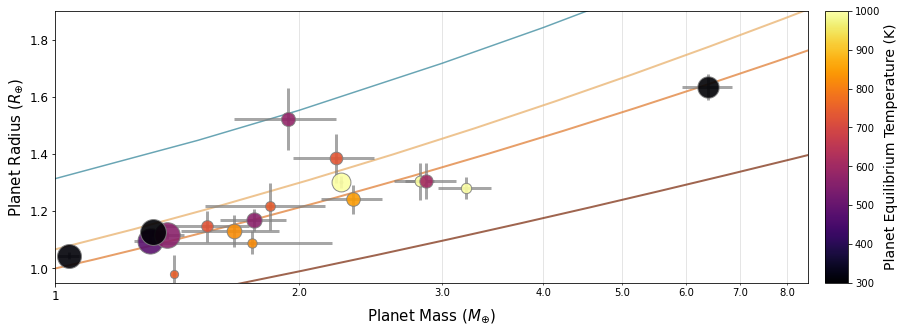

In [62]:
cmap = mpl.cm.inferno
norm = mpl.colors.Normalize(vmin=300, vmax=1000)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

#sample chosen by:
#high_rprs = np.argwhere(((pl_rad*u.R_earth)/(st_rad*u.R_sun)).decompose() > .03)

plt.figure(figsize=(15, 5))

Fe100 = ascii.read('/home/hannah/Research/Library/ZengCompositions/Fe_100.txt')
plt.plot(Fe100['col1'], Fe100['col2'], color='#873e23', lw=2, alpha=0.8)

Earthlike = ascii.read('/home/hannah/Research/Library/ZengCompositions/Fe_32p5_MgSiO3_67p5_Earth.txt')
plt.plot(Earthlike['col1'], Earthlike['col2'], color='#e28743', lw=2, alpha=0.8)

MgSiO3 = ascii.read('/home/hannah/Research/Library/ZengCompositions/MgSiO3_100.txt')
plt.plot(MgSiO3['col1'], MgSiO3['col2'], color='#eab676', lw=2, alpha=0.8)

MgSiO3_50_H2O_50 = ascii.read('/home/hannah/Research/Library/ZengCompositions/MgSiO3_50_H2O_50.txt')
plt.plot(MgSiO3_50_H2O_50['col1'], MgSiO3_50_H2O_50['col2'], color='#448fa2', lw=1.5, alpha=0.8)

plt.errorbar(smallPlanetSystems['pl_bmasse'], 
             smallPlanetSystems['pl_rade'], 
             xerr=np.mean([smallPlanetSystems['pl_bmasseerr1'], abs(smallPlanetSystems['pl_bmasseerr2'])], axis=0), 
             yerr=np.mean([smallPlanetSystems['pl_radeerr1'], abs(smallPlanetSystems['pl_radeerr2'])], axis=0),
             fmt='.',
             color='grey',
             ecolor='grey',
             elinewidth=3,
             alpha=0.7,
             zorder=500,
             )

for i in range(len(smallPlanetSystems)):
    plt.plot(smallPlanetSystems['pl_bmasse'][i],
             smallPlanetSystems['pl_rade'][i], 
             'o',
             markersize=Rp_Rs[i]*300,
             markeredgecolor='grey',
             color=mapper.to_rgba(Teq[i]),
             alpha=0.9,
             zorder=1000
            )
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', fraction=0.08, pad=0.02, aspect=12).set_label(label='Planet Equilibrium Temperature (K)', size=14)

plt.ylim(0.95, 1.9) # radius
plt.xlim(1, 8.5) # mass

plt.xscale('log')
#massrad['massrad'].set_yscale('log')
plt.xlabel('Planet Mass ($M_{\oplus}$)', fontsize=15)
plt.ylabel('Planet Radius ($R_{\oplus}$)', fontsize=15)
#plt.title('', fontsize=16)

plt.tick_params(axis='both', labelsize=12)
plt.tick_params(axis='both', which='minor')#, labelbottom=False)
plt.grid(axis='both', which='both', alpha=0.4)

plt.tick_params(axis='x', which='minor')
ax = plt.gca()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:.1f}'))

plt.grid()

#plt.savefig('Figure_TerrestrialSample.png', dpi=800)
plt.show()

In [65]:
#targ = smallPlanetSystems[targ_inds[1][0]]
targ = smallPlanetSystems[0]
targ

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_teff,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbsmax,pl_orbincl,tran_flag,rv_flag
str10,str12,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
GJ 1132,GJ 1132 b,12.613,10h14m50.18s,-47d09m17.77s,8.322,0.18,0.21,3270.0,0.5,0.056,-0.056,1.66,0.23,-0.23,1.628931,0.0153,86.58,1,1


In [40]:
# star_params
star_name = targ['hostname']
k_mag = targ['sy_kmag']

# planet params
tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                i = targ['pl_orbincl']
              )# event duration

# obs params
nobs = 4                # number of occultation obsrevations
tfrac   = 1             # how many times transit duration to observe
tsettle = 45 * u.min    # should be specific to MIRI
tcharge = 1 * u.hr      # amount of charged time becuase JWST will not start observations right away
noccultations = 1       # can always scale later
mingroups = 5           # suggested for MIRI Imaging TSO
expfact_out = 1         # bare minimum of out-of-transit baseline; but will be asking for more so not a big deal

## Set up MIRI Imaging
Set up a MIRI time-series imaging dictionary from pandeia.

Grab some key parameters to use later.

This dictionary can be updated and re-computed.

In [11]:
filter    = 'f1500w'
subarray  = 'full'
pull_default_dict = False # needs to be true if you want to pull a new default dictionary from paneia
make_new_bkg = True # should be true if working with different stars; otherwise set to False for speed

In [12]:
def get_bkg(targ, ref_wave, make_new_bkg=True):
    """
    Code to retrieve sky background from the jwst backgrounds database based on system coordinates
    JWST backgrounds: https://jwst-docs.stsci.edu/jwst-general-support/jwst-background-model
    
    Inputs:
    targ          -- dictionary of target; must include RA and Dec of system as strings
    ref_wave      -- reference wavelength for jbt to return 
    make_new_bkg  -- default=True; otherwise you can load up the last background called, 
                                   use if only working with one system
                                   
    Returns:
    background    -- list of two lists containing wavelength (um) and background counts (mJy/sr)
    """
    
    sys_coords = targ['rastr']+' '+targ['decstr']

    if make_new_bkg:
        # make astropy coordinates object
        c = SkyCoord(sys_coords, unit=(u.hourangle, u.deg))

        # use jwst backgrounds to compute background at this point
        bg = jbt.background(c.ra.deg, c.dec.deg, ref_wave)

        # background is computed for many days; choose one
        ndays = bg.bkg_data['calendar'].size
        assert ndays > 0  # make sure object is visible at some point in the year; if not check coords
        middleday = bg.bkg_data['calendar'][int(ndays / 2)] # picking the middle visible date; somewhat arbitrary!
        middleday_indx = np.argwhere(bg.bkg_data['calendar'] == middleday)[0][0]

        tot_bkg = bg.bkg_data['total_bg'][middleday_indx]
        wav_bkg = bg.bkg_data['wave_array']

        # background is [wavelength, total_background] in [micron, mJy/sr]
        background = [list(np.array(wav_bkg)), list(np.array(tot_bkg))]

        ascii.write(background, "background.txt", overwrite=True)

    else: 
        background = ascii.read("background.txt")
        background = [list(background['col0']), list(background['col1'])]
        
    return background

In [13]:
def make_miri_dict(filter, subarray, targ, pull_default_dict=True):
    """
    Code to make the initial miri dictionally for imaging_ts
    
    Inputs:
    filter            -- which photometric filter to use (e.g., f1500w)
    subarray          -- which subarray readout ot use (e.g., sub256)
    sys_coords        -- string of the coordinates of the system in RA Dec; e.g. "23h06m30.33s -05d02m36.46s";
                         to be passed to get_bkg function
    pull_default_dict -- default=True; can re-use a saved one but this doesn't save much time.
    """

    # grab default imaging ts dictionary (I think this only works online?)
    if pull_default_dict:
        miri_imaging_ts = build_default_calc('jwst', 'miri', 'imaging_ts')

        # Serializing json
        json_object = json.dumps(miri_imaging_ts, indent=4)

        # Writing to sample.json
        with open("miri_imaging_ts.json", "w") as outfile:
            outfile.write(json_object)

    else: 
        with open("miri_imaging_ts.json", "r") as f:
            miri_imaging_ts = json.load(f)
            
    if   filter == 'f1500w': ref_wave = 15 * u.micron
    elif filter == 'f1800w': ref_wave = 18 * u.micron
            
    # update with basic parameters
    miri_imaging_ts['configuration']['instrument']['filter'] = filter
    miri_imaging_ts['configuration']['detector']['subarray'] = subarray
       
    miri_imaging_ts['configuration']['detector']['ngroup']   = 2    
    miri_imaging_ts['configuration']['detector']['nint'] = 1 
    miri_imaging_ts['configuration']['detector']['nexp'] = 1
    miri_imaging_ts['configuration']['detector']['readout_pattern'] = 'fastr1'
    try: miri_imaging_ts['configuration'].pop('max_filter_leak')
    except(KeyError): pass

    miri_imaging_ts['scene'][0]['spectrum']['normalization'] = {}
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['type']          = 'photsys'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'vegamag'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['bandpass']      = 'johnson,k'
    miri_imaging_ts['scene'][0]['spectrum']['normalization']['norm_flux']     = k_mag           # change this for different stars

    miri_imaging_ts['scene'][0]['spectrum']['sed']['key']          = 'm5v'
    miri_imaging_ts['scene'][0]['spectrum']['sed']['sed_type']     = 'phoenix'
    try: miri_imaging_ts['scene'][0]['spectrum']['sed'].pop('unit')
    except(KeyError): pass

    miri_imaging_ts['background'] = get_bkg(targ, ref_wave)
    miri_imaging_ts['background_level'] = 'high'

    miri_imaging_ts['strategy']['aperture_size']  = 0.7
    miri_imaging_ts['strategy']['sky_annulus']    = [2, 2.8]

    return miri_imaging_ts

## Configure pandeia input

## Determine the optimal number of groups per integration
For MIRI this is likely slightly underestimated, so consider adding ~few groups to output.

Code blatently copie from pandexo (thanks Natasha!).

In [14]:
# if you want to calculate optiman number of groups run following, otherwise defind yourself.
def get_timing(miri_dict):
    
    report = perform_calculation(miri_dict)
    tframe   = report['information']['exposure_specification']['tframe']        * u.s
    nframe   = report['information']['exposure_specification']['nframe']
    nskip    = report['information']['exposure_specification']['nsample_skip']
    
    i = InstrumentFactory(miri_dict['configuration'])
    det_pars = i.read_detector_pars()
    fullwell = det_pars['fullwell']
    sat_level = 0.8 * fullwell

    report = perform_calculation(miri_dict, dict_report=False)
    report_dict = report.as_dict()
    
    
    #report = perform_calculation(miri_imaging_ts, dict_report=False)
    report_dict = report.as_dict() 

    # count rate on the detector in e-/second/pixel
    #det = report_dict['2d']['detector']
    det = report.signal.rate_plus_bg_list[0]['fp_pix']

    timeinfo = report_dict['information']['exposure_specification']
    #totaltime = timeinfo['tgroup']*timeinfo['ngroup']*timeinfo['nint']

    maxdetvalue = np.max(det)

    #maximum time before saturation per integration 
    #based on user specified saturation level

    try:
        maxexptime_per_int = sat_level/maxdetvalue
    except: 
        maxexptime_per_int = np.nan

    transit_duration = tdur.to(u.s).value
    frame_time = tframe.value
    overhead_per_int = tframe #overhead time added per integration 
    min_nint_trans = 3
    max_ngroup = 100
    #try: 
        #are we starting with a exposure time ?
    #    maxexptime_per_int = m['maxexptime_per_int']
    #except:
        #or a pre defined number of groups specified by user
    #    ngroups_per_int = m['ngroup']

    flag_default = "All good"
    flag_high = "All good"
    if 'maxexptime_per_int' in locals():
        #Frist, if maxexptime_per_int has been defined (from above), compute ngroups_per_int

        #number of frames in one integration is the maximum time beofre exposure 
        #divided by the time it takes for one frame. Note this does not include 
        #reset frames 

        nframes_per_int = np.floor(maxexptime_per_int/frame_time)

        #for exoplanets nframe =1 an nskip always = 0 so ngroups_per_int 
        #and nframes_per_int area always the same 
        ngroups_per_int = np.floor(nframes_per_int/(nframe + nskip)) 

        #put restriction on number of groups 
        #there is a hard limit to the maximum number groups. 
        #if you exceed that limit, set it to the maximum value instead.
        #also set another check for saturation

        if ngroups_per_int > max_ngroup:
            ngroups_per_int = max_ngroup
            flag_high = "Groups/int > max num of allowed groups"

        if (ngroups_per_int < mingroups) | np.isnan(ngroups_per_int):
            ngroups_per_int = mingroups  
            nframes_per_int = mingroups
            flag_default = "NGROUPS<"+str(mingroups)+"SET TO NGROUPS="+str(mingroups)

    elif 'ngroups_per_int' in locals(): 
        #if it maxexptime_per_int been defined then set nframes per int 
        nframes_per_int = ngroups_per_int*(nframe+nskip)

        #if that didn't work its because maxexptime_per_int is nan .. run calc with mingroups
    else:
        #if maxexptime_per_int is nan then just ngroups and nframe to 2 
        #for the sake of not returning error
        ngroups_per_int = mingroups
        nframes_per_int = mingroups
        flag_default = "Something went wrong. SET TO NGROUPS="+str(mingroups)


    #the integration time is related to the number of groups and the time of each 
    #group 
    exptime_per_int = ngroups_per_int*tframe

    #clock time includes the reset frame 
    clocktime_per_int = (ngroups_per_int+1.0)*tframe

    #observing efficiency (i.e. what percentage of total time is spent on soure)
    eff = (exptime_per_int)/(clocktime_per_int)

    #this says "per occultation" but this is just the in transit frames.. See below
    # transit duration / ((ngroups + reset)*frame time)
    nint_per_occultation =  transit_duration/((ngroups_per_int+1.0)*frame_time)

    #figure out how many integrations are in transit and how many are out of transit 
    nint_in = np.ceil(nint_per_occultation)
    nint_out = np.ceil(nint_in/expfact_out)

    #you would never want a single integration in transit. 
    #here we assume that for very dim things, you would want at least 
    #3 integrations in transit 
    if nint_in < min_nint_trans:
        ngroups_per_int = np.floor(ngroups_per_int/min_nint_trans)
        exptime_per_int = (ngroups_per_int)*tframe
        clocktime_per_int = ngroups_per_int*tframe
        eff = (ngroups_per_int - 1.0)/(ngroups_per_int + 1.0)
        nint_per_occultation =  tdur/((ngroups_per_int+1.0)*tframe)
        nint_in = np.ceil(nint_per_occultation)
        nint_out = np.ceil(nint_in/expfact_out)

    if nint_out < min_nint_trans:
        nint_out = min_nint_trans

    timing = {
        #"Transit Duration" : (transit_duration)/60.0/60.0,
        "Seconds per Frame" : tframe,
        "Time/Integration incl reset (sec)":clocktime_per_int,
        "APT: Num Groups per Integration" :int(ngroups_per_int), 
        #"Num Integrations Out of Transit":int(nint_out),
        "Num Integrations In Transit":int(nint_in),
        "APT: Num Integrations per Occultation":int(nint_out+nint_in),
        "Observing Efficiency (%)": eff*100.0,
        #"Transit+Baseline, no overhead (hrs)": (nint_out+nint_in)*clocktime_per_int/60.0/60.0, 
        "Number of Transits": noccultations
    }
    
    return timing

In [15]:
# for MIRI, this calculation underestimates the number of groups; 
# experiment with adding extra groups and checking warnings
miri_imaging_ts = make_miri_dict(filter, subarray, targ)
timing = get_timing(miri_imaging_ts)
timing

/home/hannah/programs/anaconda3/lib/python3.8/site-packages/pandeia/engine/report.py:921: RuntimeWarning: divide by zero encountered in log
  if np.log(abs(val)) < -1*precision and val != 0.0:


{'Seconds per Frame': <Quantity 2.77504 s>,
 'Time/Integration incl reset (sec)': <Quantity 49.95072 s>,
 'APT: Num Groups per Integration': 17,
 'Num Integrations In Transit': 51,
 'APT: Num Integrations per Occultation': 102,
 'Observing Efficiency (%)': <Quantity 94.44444444>,
 'Number of Transits': 1}

In [16]:
ngroup = timing['APT: Num Groups per Integration']
miri_imaging_ts['configuration']['detector']['ngroup'] = 15
report = perform_calculation(miri_imaging_ts)

print('ETC Warnings:')
print(report['warnings'])

ETC Warnings:
{}


In [17]:
tframe  = report['information']['exposure_specification']['tframe'] * u.s
tint    = tframe * ngroup                         # amount of time per integration
treset  = 1*tframe                                # reset time between each integration
cadence = tint + treset
nint    = (tdur/(tint + treset)).decompose()      # number of in-transit integrations
ref_wave = report['scalar']['reference_wavelength']                         * u.micron

print('time per single integration:', tint)
print('cadence (integration time plus reset):', cadence)
print('number of in-occultation integrations:', nint.decompose())

time per single integration: 47.17568 s
cadence (integration time plus reset): 49.95072 s
number of in-occultation integrations: 50.79616567641322


## Compute noise per integration
For star only; then will add in light curve

In [18]:
# calculate shot noise
#F_extracted = report_dict['scalar']['extracted_flux'] / u.s # electrons per sec
#var_shot = F_extracted * tgroup * (ngroup - 1) * nint + F_extracted * tgroup * (ngroup - 1) * nint
#var_shot = F_extracted * tframe * (ngroup-1)
#var_shot

In [19]:
# calculate background noise
#F_background = report_dict['scalar']['background_sky'] / u.s # electrons per sec
#var_bkg = F_background * tframe * (ngroup-1)   # times total integration time
#var_bkg

In [20]:
# calculate read noise
#rn = i.read_detector_pars()['rn']
#npix = report_dict['scalar']['extraction_area']
 
# From Bathala (2017): The factor of 2 comes from the fact that Pandeiaʼs RN values
# are given in units of e−/frame. Since we are subtracting the last frame from the first, 
# we must account for both frames
#var_read = rn**2 * npix 
#var_read

In [21]:
#var_F = var_shot + var_read + var_bkg
#print(var_F)
#sigma_F = np.sqrt(var_F)
#sigma_F

In [22]:
#F_extracted, F_background

In [23]:
def get_calibration(miri_dict):

    miri_imaging_ts_calibration = copy.deepcopy(miri_imaging_ts)

    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['sed_type']     = 'flat'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed']['unit']         = 'flam'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['sed'].pop('key')

    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['type']          = 'at_lambda'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_wave']     = 2
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_waveunit'] = 'um'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_flux']     = 1e-18
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'flam'
    miri_imaging_ts_calibration['scene'][0]['spectrum']['normalization'].pop('bandpass')
    
    return miri_imaging_ts_calibration

In [24]:
miri_imaging_ts_calibration = get_calibration(miri_imaging_ts)
report_calibration = perform_calculation(miri_imaging_ts_calibration)
print('Calibartion Warnings:')
print(report_calibration['warnings'])

Calibartion Warnings:
{}


In [25]:
#time = np.linspace(-0.5, 0.5, 500)
#flux = np.ones(len(time))
#npts = 500
#time = np.linspace(-0.3, 0.3, npts)

In [26]:
# Creating a star
M_s  = 1
R_s  = 1
prot = 1

starA = st.Primary(
    st.Map(ydeg = 1, udeg = 2, nw = 1, amp = 1.0), 
    m    = M_s,
    r    = R_s, 
    prot = prot
)
#print(starA.map.amp)
#print(starA.map.udeg)
#starA.map.show()

Pre-computing some matrices... Done.


In [27]:
# adapted from Mette's code
def make_planet(plnt, phase=0, t0=0, tidally_locked=True):
    m_p     = ((plnt['pl_bmasse']*u.M_earth)/(plnt['st_mass']*u.M_sun)).decompose()
    r_p     = ((plnt['pl_bmasse']*u.R_earth)/(plnt['st_mass']*u.R_sun)).decompose()
    porb    = plnt['pl_orbper']
    prot    = plnt['pl_orbper']
    Omega   = 0
    ecc     = 0
    w       = 90
    t0      = t0
    theta0  = 180
    inc     = plnt['pl_orbincl']

    planet  = st.kepler.Secondary(
        st.Map(ydeg = 5, nw = 1, amp = 5e-3),               
        m      = m_p,                                
        r      = r_p,                          
        porb   = porb,                                                      
        prot   = prot,                                       
        Omega  = Omega,                                         
        ecc    = ecc,                                                         
        w      = w,                                  
        t0     = t0,                           
        theta0 = theta0,                           
        inc    = inc                             
    )
    
    if tidally_locked:
        planet.map.spot(contrast = -1, radius = 60)
        
    return planet

In [28]:
def flux_amplitude(T_s, T_p, wavelength, R_s, R_p):
    
    ''' This function will take in the Temperature in Kelvin, 
    and the wavelength range that we are looking at,
    as well as the the radius of the star and the planet. '''
    
    bb_s = BlackBody(T_s, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    bb_p = BlackBody(T_p, scale=1*u.erg/u.s/u.cm**2/u.AA/u.sr)
    
    Flux_ratio = bb_p(wavelength)/bb_s(wavelength) * (R_p/R_s)**2
        
    return Flux_ratio.decompose()

def T_day(T_s, R_s, a, albedo, atmo='bare rock'):
    # can be 'bare rock' or 'equilibrium'
    if   atmo == 'bare rock': f = 2/3
    elif atmo == 'equilibrium': f = 1/4
    
    T_day = T_s * np.sqrt((R_s/a).decompose()) * (1 - albedo)**(1/4) * f**(1/4)
    
    return T_day

In [29]:
T_rock = T_day(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, 0, atmo='bare rock')
amp_rock = flux_amplitude(targ['st_teff']*u.K, T_rock, ref_wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)

T_atmo = T_day(targ['st_teff']*u.K, targ['st_rad']*u.R_sun, targ['pl_orbsmax']*u.AU, 0, atmo='equilibrium')
amp_atmo = flux_amplitude(targ['st_teff']*u.K, T_atmo, ref_wave, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)

print(amp_rock, amp_atmo)
planet_b = make_planet(targ)
planet_b.map.amp = amp_rock



Pre-computing some matrices... Done.
Compiling `spot`...

0.0003939295357098993 0.00020170245768379966


 Done.


In [30]:
#plnt_c_phase = 0.25

#plnt_c = smallPlanetSystems[targ_inds[0][0]]
#T_c_rock = T_day(plnt_c['st_teff']*u.K, plnt_c['st_rad']*u.R_sun, plnt_c['pl_orbsmax']*u.AU, 0, atmo='bare rock')
#amp_c = flux_amplitude(plnt_c['st_teff']*u.K, T_c_rock, 15*u.micron, plnt_c['st_rad']*u.R_sun, plnt_c['pl_rade']*u.R_earth)
#planet_c = make_planet(plnt_c, t0=0.5*targ['pl_orbper'] - plnt_c_phase*plnt_c['pl_orbper'])
#planet_c.map.amp = amp_c

In [31]:
system = st.System(starA, planet_b)#, planet_c)

In [41]:
snr = report['scalar']['sn']
extracted_flux = report['scalar']['extracted_flux'] / u.s
extracted_noise = report['scalar']['extracted_noise'] / u.s

calibration_extracted_flux = report_calibration['scalar']['extracted_flux'] / u.s
calibration_norm_value = report_calibration['input']['scene'][0]['spectrum']['normalization']['norm_flux']

extracted_flux, extracted_noise, calibration_extracted_flux * calibration_norm_value

#signal = extracted_flux * tint
#noise  = extracted_noise * tint
signal = extracted_flux / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA
noise  = extracted_noise / calibration_extracted_flux * calibration_norm_value  * u.erg/u.s/u.cm**2/u.AA

noise /= np.sqrt(nobs)

In [42]:
tstart = (targ['pl_orbper']*0.5 - targ['pl_orbper']*0.1) * u.day
tend   = (targ['pl_orbper']*0.5 + targ['pl_orbper']*0.1) * u.day
trange = tend - tstart
total_int = int(np.ceil((trange/cadence).decompose()))

signal_ts = np.ones(total_int)*signal
scatter_ts = np.random.normal(0, noise.value, total_int) * u.erg/u.s/u.cm**2/u.AA
signal_ts_scatter = signal_ts.value + scatter_ts.value

time = np.linspace(tstart.value, tend.value, total_int) # times in... days?
time
#%matplotlib
#plt.figure(figsize=(15, 4))
#plt.plot(time, signal_ts_scatter, '.')
#plt.plot(time, signal_ts, '-')

array([0.9687748 , 0.96935352, 0.96993224, 0.97051096, 0.97108967,
       0.97166839, 0.97224711, 0.97282583, 0.97340455, 0.97398327,
       0.97456199, 0.9751407 , 0.97571942, 0.97629814, 0.97687686,
       0.97745558, 0.9780343 , 0.97861301, 0.97919173, 0.97977045,
       0.98034917, 0.98092789, 0.98150661, 0.98208533, 0.98266404,
       0.98324276, 0.98382148, 0.9844002 , 0.98497892, 0.98555764,
       0.98613636, 0.98671507, 0.98729379, 0.98787251, 0.98845123,
       0.98902995, 0.98960867, 0.99018739, 0.9907661 , 0.99134482,
       0.99192354, 0.99250226, 0.99308098, 0.9936597 , 0.99423841,
       0.99481713, 0.99539585, 0.99597457, 0.99655329, 0.99713201,
       0.99771073, 0.99828944, 0.99886816, 0.99944688, 1.0000256 ,
       1.00060432, 1.00118304, 1.00176176, 1.00234047, 1.00291919,
       1.00349791, 1.00407663, 1.00465535, 1.00523407, 1.00581279,
       1.0063915 , 1.00697022, 1.00754894, 1.00812766, 1.00870638,
       1.0092851 , 1.00986381, 1.01044253, 1.01102125, 1.01159

In [43]:
flux = np.hstack(system.flux(time))


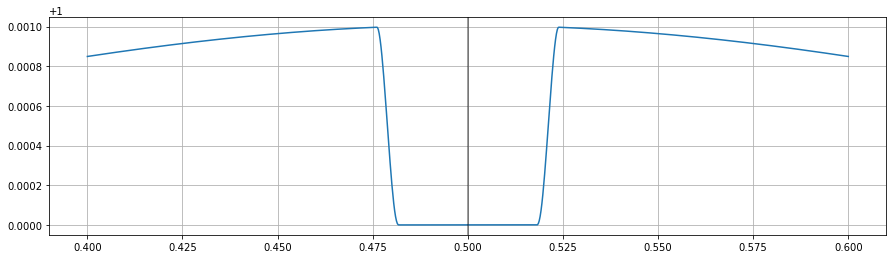

In [44]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(time/targ['pl_orbper'], flux)
plt.axvline(0.5, color='k', alpha=0.5)
#plt.ylim(0.988, 1.001)
plt.grid()

In [45]:
signal_ts_scatter_binned, time_bin_edges, _ = stats.binned_statistic(time, signal_ts_scatter*flux, bins=25)
time_bin_width = np.mean(np.diff(time_bin_edges))
time_binned = time_bin_edges[:-1] + time_bin_width/2

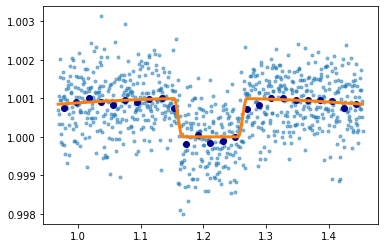

In [46]:
plt.plot(time, signal_ts_scatter*flux/signal, '.', alpha=0.5)
plt.plot(time_binned, signal_ts_scatter_binned/signal, 'o', alpha=1, color='darkblue')
plt.plot(time, signal_ts*flux/signal, '-', lw=3)

In [47]:
wave_range = np.linspace(0.7, 25, 100) *u.micron
Fp_Fs_rock = flux_amplitude(targ['st_teff']*u.K, T_rock, wave_range, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)
Fp_Fs_atmo = flux_amplitude(targ['st_teff']*u.K, T_atmo, wave_range, targ['st_rad']*u.R_sun, targ['pl_rade']*u.R_earth)

yerr = 1/report['scalar']['sn'] / np.sqrt(nint) / np.sqrt(nobs)
ref_wave

<Quantity 14.93311096 micron>

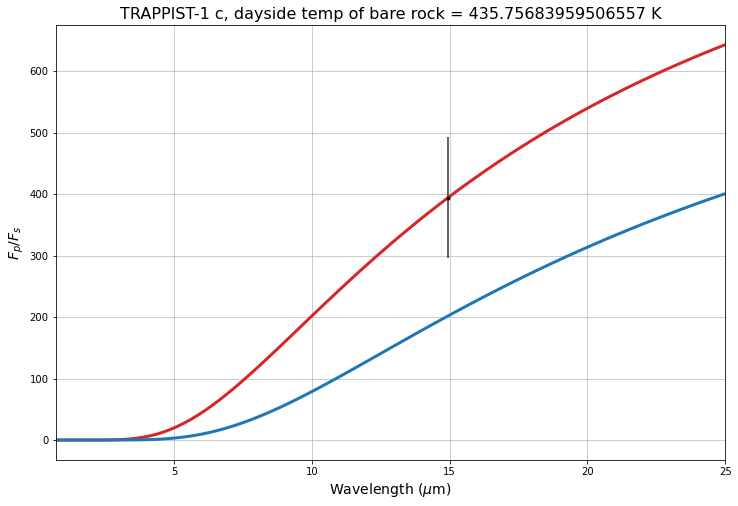

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(wave_range, Fp_Fs_rock *1e6, lw=3, color='C3')
plt.plot(wave_range, Fp_Fs_atmo *1e6, lw=3, color='C0')


plt.errorbar(ref_wave.value, amp_rock *1e6, yerr=yerr.value *1e6, fmt='.', color='k', alpha=0.8)

plt.ylabel('$F_p$/$F_s$', fontsize=14)
plt.xlabel('Wavelength ($\mu$m)', fontsize=14)
plt.title(targ['pl_name']+f', dayside temp of bare rock = {T_rock}', fontsize=16)

plt.xlim(0.7, 25)
plt.grid(alpha=0.8)

In [36]:
signal, nint

(<Quantity 2.56308583e-17 erg / (Angstrom cm2 s)>, <Quantity 569.62543037>)

In [37]:
noise / signal

<Quantity 0.0005303>

In [38]:
signal/noise

<Quantity 1885.7226883>

In [39]:
report['scalar']['sn'] 

1333.4073003340684

In [40]:
noise/signal / np.sqrt(nint) / np.sqrt(4)


<Quantity 1.11095762e-05>

In [41]:
100e-6

0.0001

In [42]:
7.66e-6 / 4e-4

0.019149999999999997

In [43]:
targ

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_teff,pl_rade,pl_bmasse,pl_orbper,pl_orbsmax,pl_orbincl,tran_flag,rv_flag
str10,str12,float64,str12,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
GJ 3929,GJ 3929 b,15.8095,15h58m18.62s,+35d24m29.21s,7.869,0.31,0.32,3384.0,1.09,1.75,2.616235,0.0252,88.442,1,1
